In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE




In [2]:
# Muat dataset
data = pd.read_csv('heart.csv')

# Hapus duplikasi data
data = data.drop_duplicates()

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
# Analisis deskriptif data
print(data.describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [8]:
# Cek nama kolom dalam dataset
print("Nama Kolom dalam Dataset:", data.columns)

Nama Kolom dalam Dataset: Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


In [9]:
# Cek nilai yang hilang
print("Nilai yang Hilang:", data.isnull().sum())

Nilai yang Hilang: Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


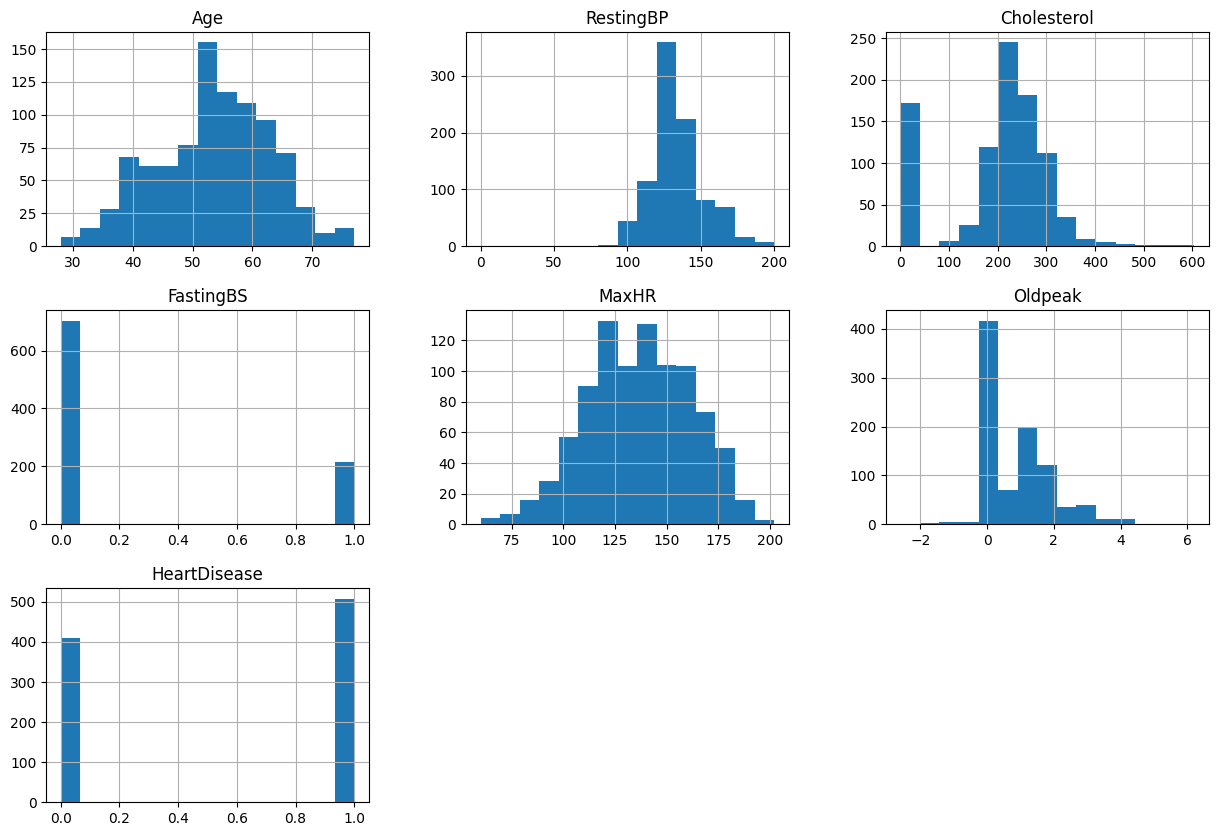

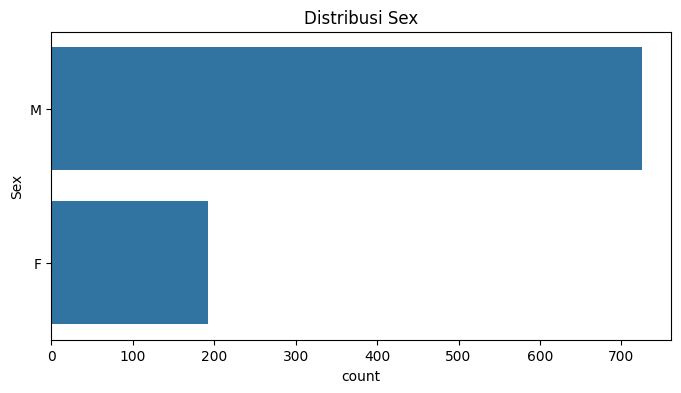

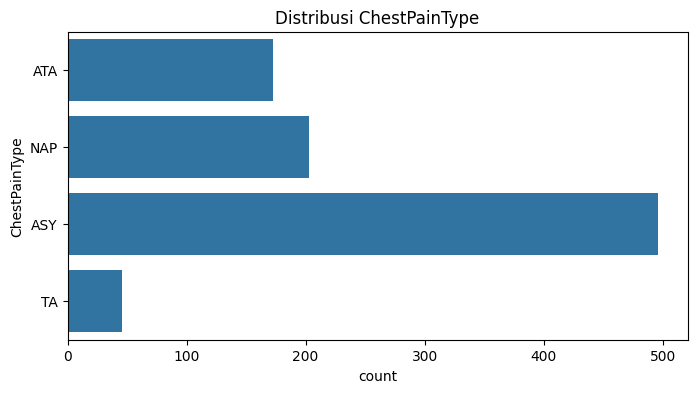

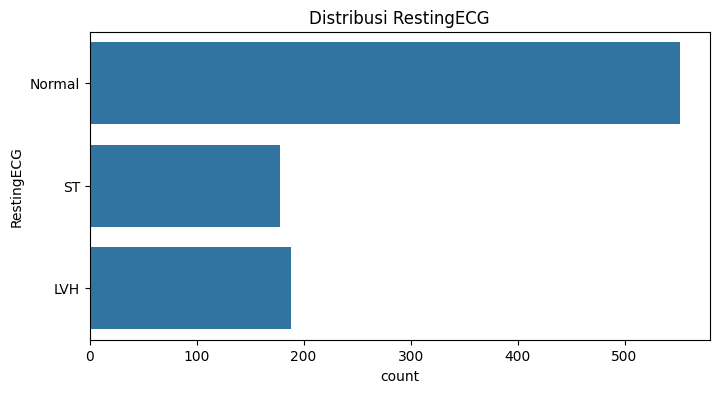

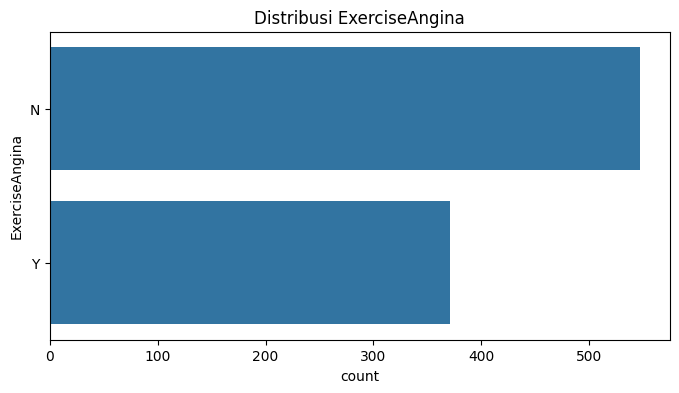

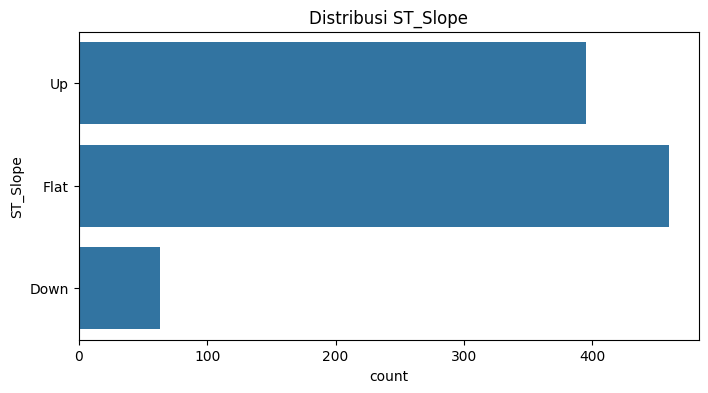

In [10]:
# Visualisasi distribusi fitur numerik
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_features].hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.show()

# Visualisasi distribusi fitur kategori
categorical_features = data.select_dtypes(include=['object']).columns
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])
    plt.title(f'Distribusi {col}')
    plt.show()


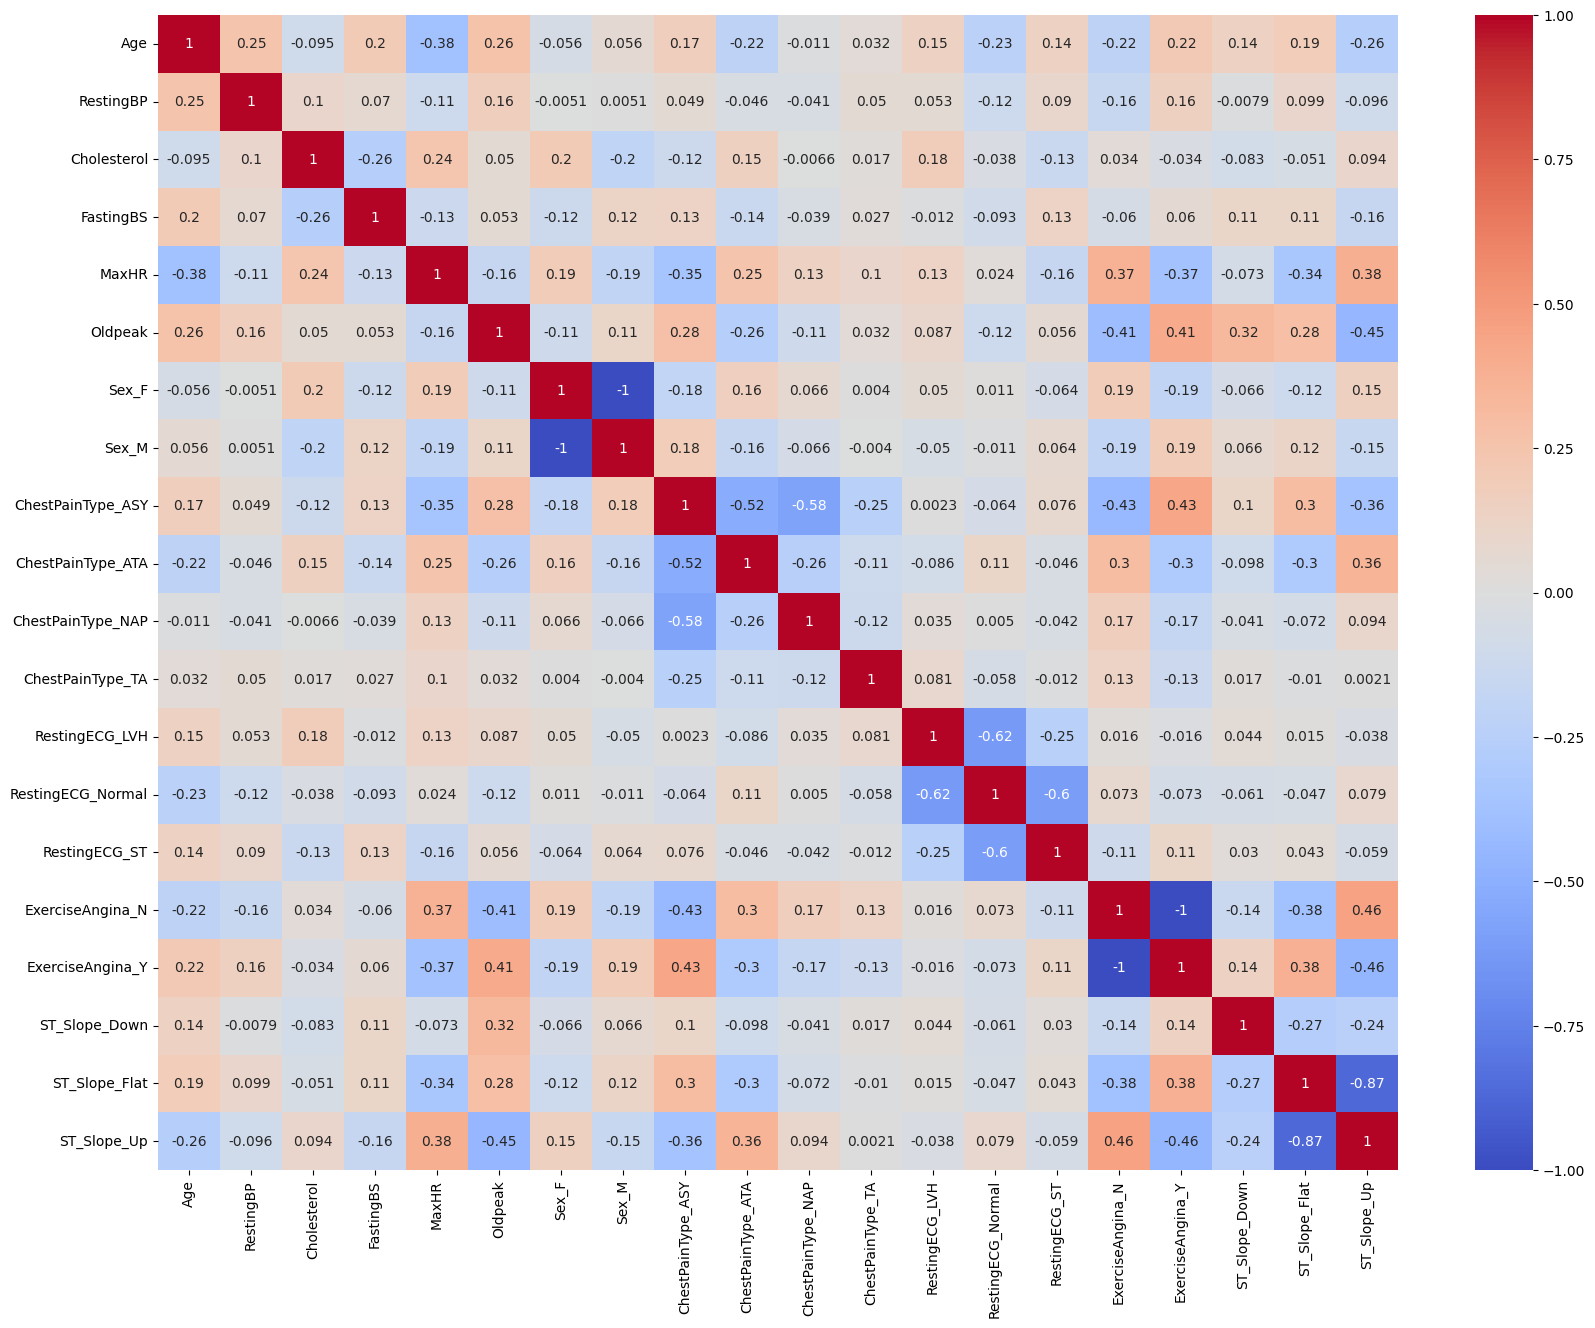

In [24]:
# Encoding fitur kategori untuk analisis korelasi
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X_encoded = pd.get_dummies(data.drop('HeartDisease', axis=1), columns=categorical_features)
y = data['HeartDisease']

# Analisis korelasi
plt.figure(figsize=(20, 15))
sns.heatmap(X_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()

# Identifikasi fitur dengan korelasi rendah terhadap target
correlation_threshold = 0.1
correlation_with_target = X_encoded.corrwith(y)
low_correlation_features = correlation_with_target[correlation_with_target.abs() < correlation_threshold].index.tolist()

# Drop fitur dengan korelasi rendah
X_encoded = X_encoded.drop(columns=low_correlation_features)


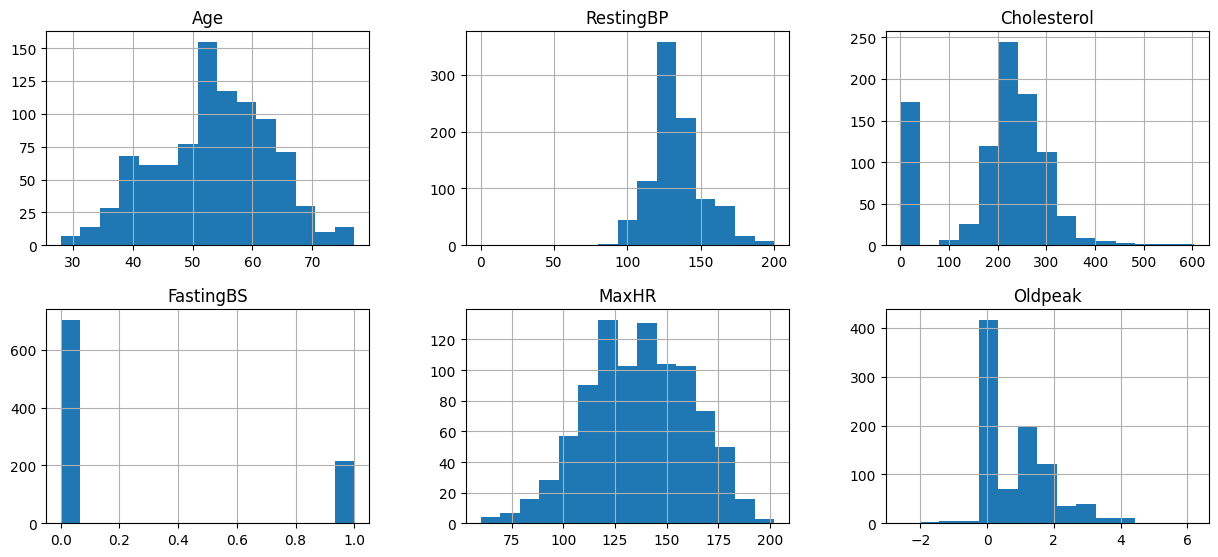

In [28]:
# Visualisasi distribusi fitur setelah drop
X_encoded.hist(bins=15, figsize=(15, 10), layout=(3, 3))
plt.show()


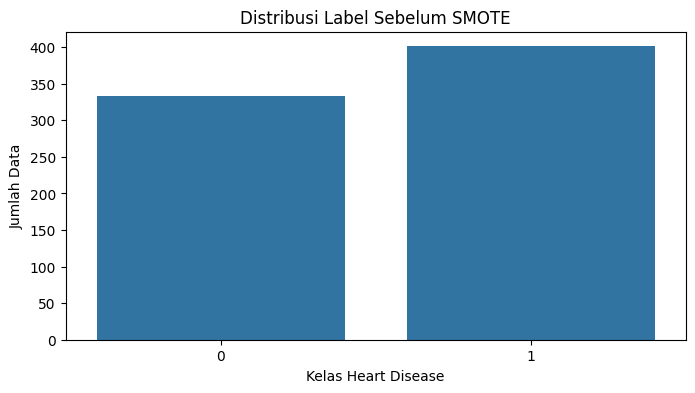

In [25]:
# Pisahkan kembali fitur yang telah diencoding dan label
X = X_encoded

# Encoding fitur kategori
numerical_features = X.columns.difference(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), [col for col in categorical_features if col in X.columns])
    ])

# Bagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Terapkan preprocessing ke data latih dan data uji
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Visualisasi distribusi label sebelum SMOTE
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)  # Mengatur sumbu x dan y dengan benar
plt.xlabel('Kelas Heart Disease')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Label Sebelum SMOTE')
plt.show()

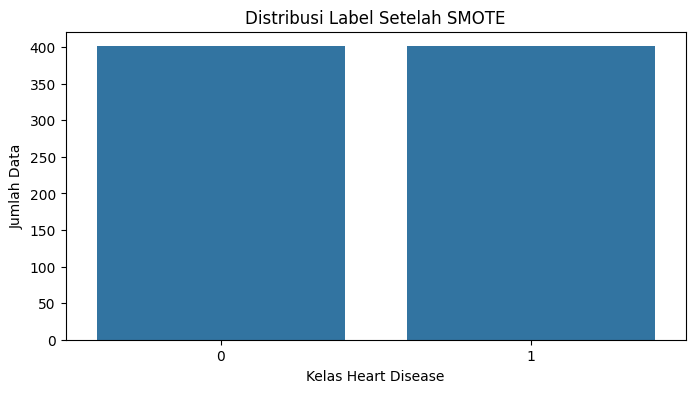

Distribusi label setelah SMOTE:
HeartDisease
0    401
1    401
Name: count, dtype: int64


In [20]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Visualisasi distribusi label setelah SMOTE
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.xlabel('Kelas Heart Disease')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Label Setelah SMOTE')
plt.show()

print("Distribusi label setelah SMOTE:")
print(y_train.value_counts())

In [26]:
# Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8804347826086957
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        77
           1       0.91      0.88      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

